In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
import tensorflow as tf
from keras.callbacks import EarlyStopping

config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config)) 
print('configed')

Using TensorFlow backend.


configed


In [2]:
# path to the model weights files.


# dimensions of our images.
img_width, img_height = 224, 224
train_data_dir = 'D:\\EE628\\final_dogs&cats\\data\\train'
validation_data_dir = 'D:\\EE628\\final_dogs&cats\\data\\validation'
predict_data_dir = 'D:\\EE628\\final_dogs&cats\\data\\test'
path_folder='D:\\EE628\\final_dogs&cats\\Traning\\'
epochs = 100
batch_size = 64


In [3]:
#设置图像生成器
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

predict_generator = test_datagen.flow_from_directory(
    predict_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,)

print("Image prepared")

Found 16666 images belonging to 2 classes.
Found 8334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Image prepared


In [4]:
input_shape = (img_width, img_height,3)
vgg16_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(path_folder+'3_top_weight.h5')

In [5]:
#del model
model = Model(input= vgg16_model.input, output= top_model(vgg16_model.output))
# set the first 25 layers (up to the last conv block)
for layer in model.layers[:25]:
    layer.trainable = False
model.summary()

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.03, patience=5, 
                            mode='max')
callbacks_list = [earlystop]
# fine-tune the model
hist_FineTune=model.fit_generator(
                train_generator,
                steps_per_epoch=16666// batch_size+1,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=8334// batch_size+1,
                callbacks=callbacks_list)
model.save_weights(path_folder+'3_2_vgg16_finetune.h5')
print('Weight saved')

C:\Users\Administrator\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

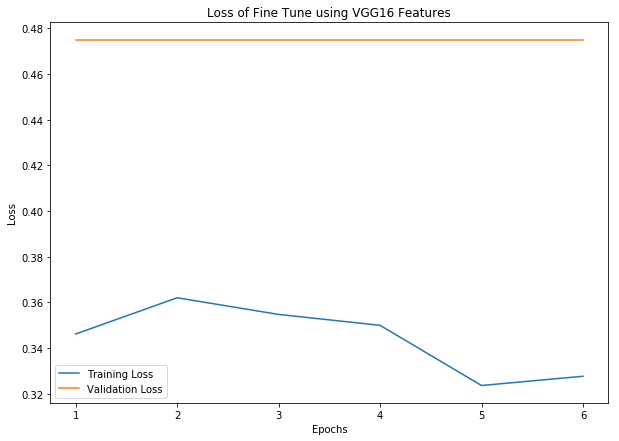

Plot saved


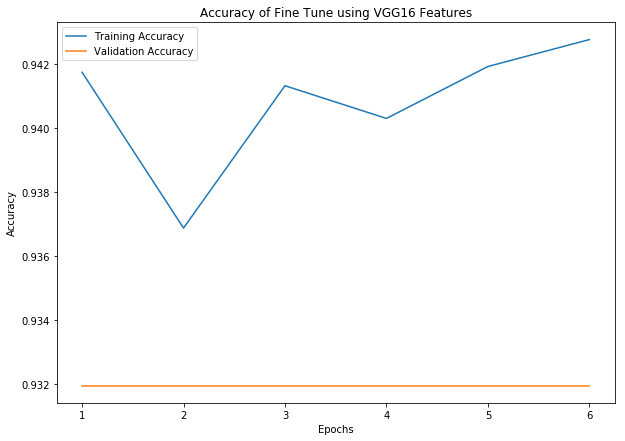

Plot saved


In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7)) 
epochs = range(1, len(hist_FineTune.history['acc']) + 1)
plt.plot(epochs, hist_FineTune.history['loss'], label='Training Loss') 
plt.plot(epochs, hist_FineTune.history['val_loss'], label='Validation Loss') 

plt.title('Loss of Fine Tune using VGG16 Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path_folder+'3_2_loss_FineTune_vgg16.jpg')
plt.show()
print('Plot saved')

plt.figure(figsize=(10,7)) 
epochs = range(1, len(hist_FineTune.history['acc']) + 1)
plt.plot(epochs, hist_FineTune.history['acc'], label='Training Accuracy') 
plt.plot(epochs, hist_FineTune.history['val_acc'], label='Validation Accuracy') 
plt.title('Accuracy of Fine Tune using VGG16 Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(path_folder+'3_2_acc_FineTune_vgg16.jpg')
plt.show()
print('Plot saved')